In [3]:
pip install pandas numpy matplotlib scikit-learn tensorflow


Note: you may need to restart the kernel to use updated packages.


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Loading AAPL historical dataset downloaded from Investing.com
filename = "AAPL.csv"  
raw = pd.read_csv(filename)


In [10]:
df = raw.copy()
df.columns = [c.strip() for c in df.columns]

# Investing.com usually uses 'Price' for Close price
if "Price" in df.columns and "Close" not in df.columns:
    df.rename(columns={"Price": "Close"}, inplace=True)

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

df["Close"] = (
    df["Close"].astype(str)
    .str.replace(",", "", regex=False)
    .str.strip()
)
df["Close"] = pd.to_numeric(df["Close"], errors="coerce")

df = df[["Date", "Close"]].dropna()
df = df.sort_values("Date").reset_index(drop=True)

print("Rows after cleaning:", len(df))
df.head()


Rows after cleaning: 3521


,Date,Close
0,2012-01-03,14.69
1,2012-01-04,14.77
2,2012-01-05,14.93
3,2012-01-06,15.09
4,2012-01-09,15.06


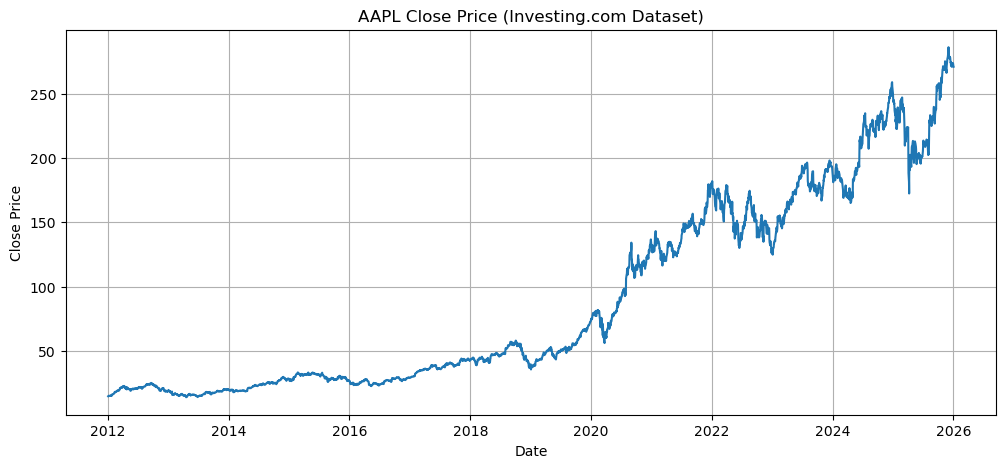

In [12]:
plt.figure(figsize=(12,5))
plt.plot(df["Date"], df["Close"])
plt.title("AAPL Close Price (Investing.com Dataset)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()


In [14]:
close_prices = df["Close"].values.reshape(-1, 1)

scaler = MinMaxScaler()
scaled = scaler.fit_transform(close_prices)

SEQ_LEN = 60
if len(scaled) <= SEQ_LEN:
    SEQ_LEN = max(5, len(scaled)//3)
    print("Dataset small → SEQ_LEN changed to:", SEQ_LEN)

X, y = [], []
for i in range(SEQ_LEN, len(scaled)):
    X.append(scaled[i-SEQ_LEN:i, 0])
    y.append(scaled[i, 0])

X = np.array(X).reshape(-1, SEQ_LEN, 1)
y = np.array(y)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

test_dates = df["Date"].iloc[SEQ_LEN + split:].reset_index(drop=True)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (2768, 60, 1) Test: (693, 60, 1)


In [16]:
tf.random.set_seed(42)

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LEN, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer="adam", loss="mean_squared_error")

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=32,
    verbose=1
)


C:\Users\ACER\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 0.0037 - val_loss: 0.0012
Epoch 2/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 6.9123e-04 - val_loss: 9.4685e-04
Epoch 3/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 6.1499e-04 - val_loss: 0.0023
Epoch 4/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 4.8101e-04 - val_loss: 0.0018
Epoch 5/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 5.0413e-04 - val_loss: 0.0028
Epoch 6/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 3.9941e-04 - val_loss: 0.0028
Epoch 7/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 4.1351e-04 - val_loss: 7.9229e-04
Epoch 8/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 4.1175e-04 - val_loss: 6.7763e-04
Epoch 9/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 3.7520e-04 - val_loss: 6.5442e-04
Epoch 10/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 3.9673e-04 - val_loss: 0.0012
Epoch 11/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 3.9789e-04 - val_loss: 6.2397e-04
Ep

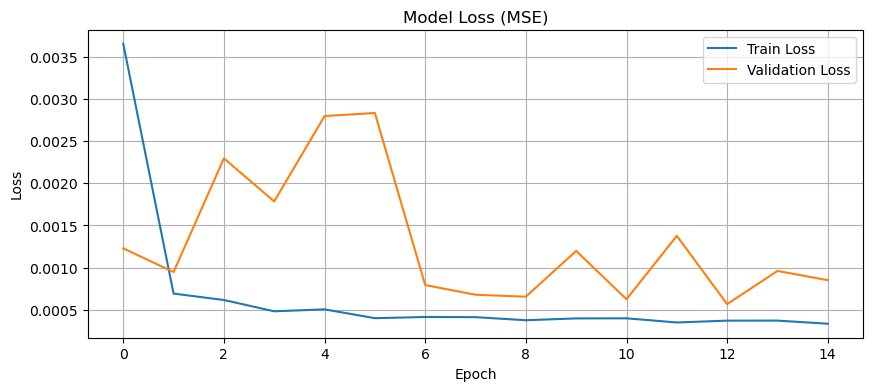

In [18]:
plt.figure(figsize=(10,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


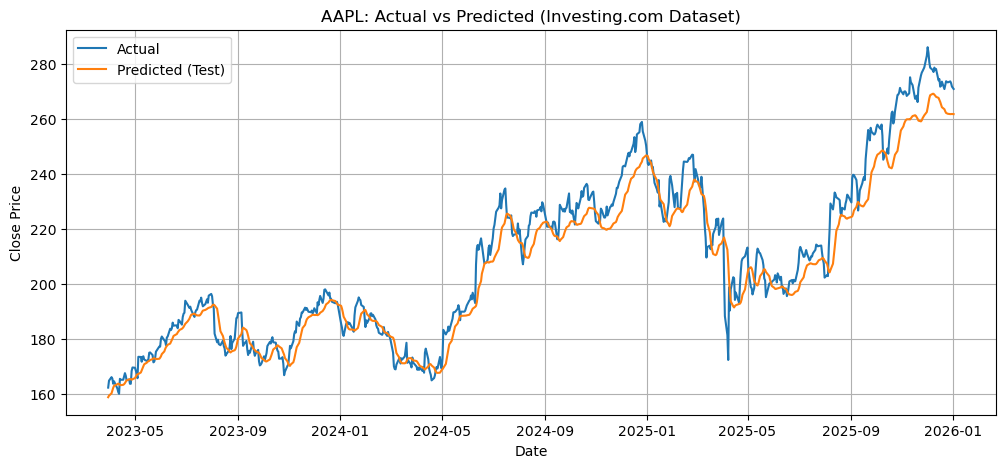

In [20]:
pred_scaled = model.predict(X_test)
pred = scaler.inverse_transform(pred_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1,1))

plt.figure(figsize=(12,5))
plt.plot(test_dates, actual, label="Actual")
plt.plot(test_dates, pred, label="Predicted (Test)")
plt.title("AAPL: Actual vs Predicted (Investing.com Dataset)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


C:\Users\ACER\AppData\Local\Temp\ipykernel_16416\252250287.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [float(pred[-1]), next_close],


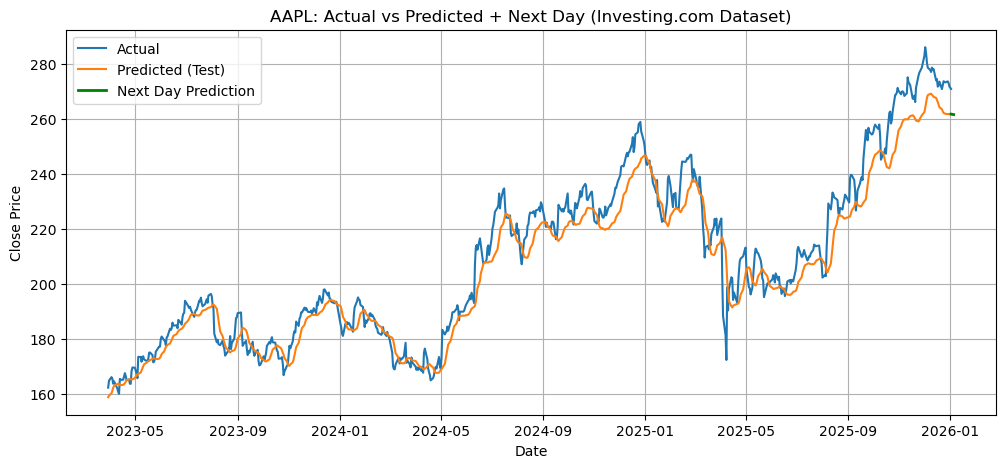

Next day predicted close: 261.68597412109375
Prediction date: 2026-01-05


In [22]:
last_seq = scaled[-SEQ_LEN:].reshape(1, SEQ_LEN, 1)
next_scaled = model.predict(last_seq)
next_close = float(scaler.inverse_transform(next_scaled)[0, 0])

last_date = pd.to_datetime(df["Date"].iloc[-1])
next_date = pd.bdate_range(last_date + pd.Timedelta(days=1), periods=1)[0]

plt.figure(figsize=(12,5))
plt.plot(test_dates, actual, label="Actual")
plt.plot(test_dates, pred, label="Predicted (Test)")

plt.plot(
    [pd.to_datetime(test_dates.iloc[-1]), next_date],
    [float(pred[-1]), next_close],
    linewidth=2,
    color="green",
    label="Next Day Prediction"
)

plt.title("AAPL: Actual vs Predicted + Next Day (Investing.com Dataset)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.legend()
plt.show()

print("Next day predicted close:", next_close)
print("Prediction date:", next_date.date())
